In [72]:
import itertools

import graph_tool.all as gt

import numpy as np
import scipy as sp
import scipy.stats as sps

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import *

%matplotlib inline
%autosave 15

Autosaving every 15 seconds


Сгенерируем случайные графы в модели Эрдёша-Реньи (ну, почти; в graph-tool ничего более похожего сделать не удалось):

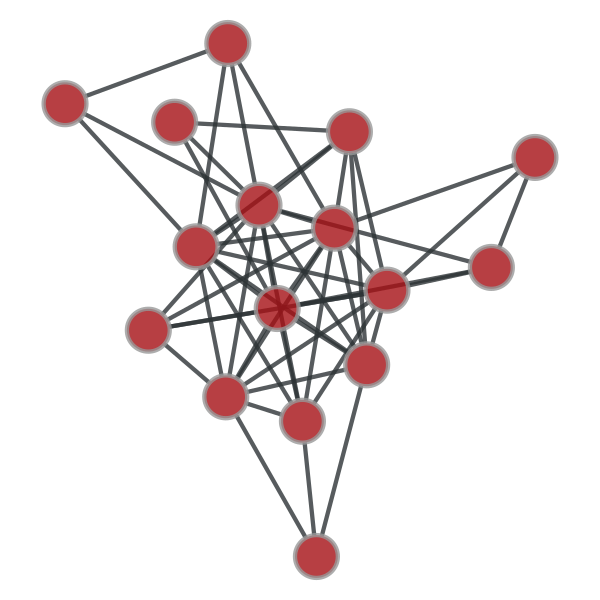

In [73]:
n, k, p = 16, 4, 0.5
# G = gt.Graph(directed=False)
# w = G.new_edge_property("double")
# c = G.new_vertex_property("string")
# for i in range(n):
#     v = G.add_vertex()
#     c[v] = "blue" if i == 0 else "red"
# G.vertex_properties["fill_color"] = c
# for i in range(1, n):
#     w[G.add_edge(0, i)] = 1
#     w[G.add_edge(i, max(1, (i + 1) % n))] = 2
# gt.graph_draw(G, vertex_fill_color=c);
G = gt.random_graph(n, lambda: np.random.poisson(n * p), directed=False);
gt.graph_draw(G);

Подсчитаем матрицу кратчайших расстояний алгоритмом Флойда.

In [74]:
w = G.new_edge_property("double")
w.a = np.random.rand(G.num_edges()) * 42
sd = gt.shortest_distance(G, weights=w, directed=False, dense=True)
sd_a = np.vstack([
    [sd[v] for v in G.vertices()]
])

Выделим мин.остов в подграфе, индуцированном терминальными вершинами (здесь нужно убедиться, что я понимаю, что делаю).

In [75]:
KG = gt.complete_graph(n, directed=False)
sd_w = KG.new_edge_property("double")
for e in KG.edges():
    u, v = int(e.source()), int(e.target())
    sd_w[e] = sd_a[u, v]
V0 = np.random.choice(np.arange(n), k)
print(V0)
V0_vfilt = G.new_vertex_property("bool")
V0_vfilt.a[V0] = True
KG_V0_induced = gt.GraphView(KG, vfilt=V0_vfilt.a)
KG_V0_w = KG_V0_induced.new_vertex_property("double")
MST = gt.min_spanning_tree(KG_V0_induced, weights=sd_w)

[14 10  7  4]


Подсчитаем его вес:

In [76]:
mst_cost = 0
for e in KG_V0_induced.edges():
    if MST[e]:
        mst_cost += sd_w[e]
print(mst_cost)

54.28858220944282


Сравним с весом реального дерева Штейнера (а как его подсчитать?):

In [77]:
def powerset(iterable):
    s = list(iterable)
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)+1))

st_cost = np.inf
# перебор подмножеств легко распараллеливается
# все операции цикла независимы друг от друга
for s in tqdm_notebook(powerset(np.setdiff1d(np.arange(n), V0))):
    mask = np.full(n, False)
    mask[V0] = True
    if len(s) > 0:
        mask[np.array(s)] = True
    H = gt.GraphView(G, vfilt=mask)
    conn = gt.label_largest_component(H)
    if np.sum(conn.a) != np.sum(mask):
        continue # not connected
    H_MST = gt.min_spanning_tree(H, weights=w)
    h_mst_cost = np.sum(w.a[H_MST.a == 1])
#     for e in H.edges():
#         if H_MST[e]:
#             h_mst_cost += w[e]
    st_cost = min(h_mst_cost, st_cost)

print(st_cost, mst_cost, mst_cost / st_cost)
# ST = gt.min_spanning_tree(G, weights=w)
# st_cost = 0
# for e in G.edges():
#     if ST[e]:
#         st_cost += w[e]
# print(st_cost)

# paths = gt.all_paths(G, source=V0[0], target=V0[-1])
# mincost = np.inf
# for path in paths:
#     if np.all(np.isin(V0, path)):
#         cost = 0
#         for i in range(len(path) - 1):
#             cost += w[G.edge(path[i], path[i+1])]
#         mincost = min(mincost, cost)
# print(mincost)


49.38653535717663 54.28858220944282 1.0992587719874107
